In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
from script import eval

In [2]:
def add_output_constraints(model, nn_layer_out_bounds, label, output_vars, sovler_bound=1e-3):
    out_lb = nn_layer_out_bounds[-1][0]
    out_ub = nn_layer_out_bounds[-1][1]
    difference_lb = out_lb - out_ub[label]
    difference_ub = out_ub - out_lb[label]
    difference_lb = difference_lb.tolist()
    difference_ub = difference_ub.tolist()
    difference_lb.pop(label)
    difference_ub.pop(label)
    min_diff = min(difference_lb)
    max_diff = max(difference_ub)

    difference = model.addVars(9, lb=difference_lb, ub=difference_ub, name="diff_var")
    model.addConstrs((difference[i] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(0, label)), name="diff_const0")
    model.addConstrs((difference[i - 1] == output_vars.tolist()[i] - output_vars.tolist()[label] for i in range(label + 1, 10)), name="diff_const1")

    max_var = model.addVar(lb=min_diff, ub=max_diff, name="max_var")
    model.addConstr(max_var == grp.max_(difference))

    model.setParam("BestObjStop", sovler_bound)

    model.update()
    model.setObjective(max_var, grp.GRB.MAXIMIZE)


In [3]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [4]:
def get_output_vars_snv_milp(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("affine_var{}[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [5]:
def get_output_vars_dhov(model, output_size, output_layer_index):
    output_vars = []
    for i in range(output_size):
        output_vars.append(model.getVarByName("output_layer_[{}]_[{}]".format(output_layer_index, i)))
    output_vars = grp.MVar.fromlist(output_vars)
    return output_vars

In [6]:
def optimize_model(model, output_vars):
    start = time.time()
    model.update()
    model.optimize()
    if model.Status == grp.GRB.OPTIMAL or model.Status == grp.GRB.USER_OBJ_LIMIT:
        for i, var in enumerate(output_vars.tolist()):
            print("var {}: {}".format(i, var.getAttr("x")))
        max_var = model.getVarByName("max_var").getAttr("x")
        if max_var < 0:
            print("property verified with max difference {}".format(max_var))
            return True
        else:
             print("property NOT verified with max difference {}".format(max_var))
             return False

    elif model.Status == grp.GRB.INFEASIBLE:
        print("model infeasible")

        model.computeIIS()
        print("constraint")
        all_constr = model.getConstrs()

        for const in all_constr:
            if const.IISConstr:
                print("{}".format(const))

        print("lower bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISLB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

        print("upper bound")
        all_var = model.getVars()
        for var in all_var:
            if var.IISUB:
                print("{}, lb: {}, ub: {}".format(var, var.getAttr("lb"), var.getAttr("ub")))

    print("time to optimize: {}".format(time.time() - start))
    return False

In [7]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

"""nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device('cpu')), strict=False)"""

"""nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc_6x256.pth", map_location=torch.device('cpu')), strict=False)"""

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
nn.load_state_dict(torch.load("../../mnist_fc 4x256.pth", map_location=torch.device('cpu')), strict=False)


parameter_list = list(nn.parameters())

output_size = 10
number_layer = (len(parameter_list) - 2) // 2

=========================================== 18 ===========================================


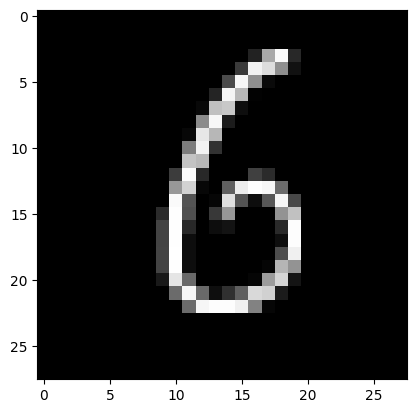

6
tensor([-172.0694, -176.8615, -162.1011, -177.4311, -169.6750, -166.8041,
        -183.9420, -177.7420, -171.6015, -172.2942], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([161.3770, 166.0988, 169.6522, 170.3519, 179.9586, 193.6648, 167.5022,
        195.0780, 178.0849, 175.9675], dtype=torch.float64,
       grad_fn=<AddBackward0>)
nn classifies image correct as 6


In [8]:
image_index = 18
eps = 0.009
use_milp = False


print("=========================================== {} ===========================================".format(image_index))
image, label = training_data.__getitem__(image_index)
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(label)

input_flattened = torch.flatten(torch_image)
simple_bounds_affine_out, simple_bounds_layer_out = nn.calculate_box_bounds([input_flattened.add(-eps), input_flattened.add(eps)])
print(simple_bounds_affine_out[-1][0])
print(simple_bounds_affine_out[-1][1])

if torch.argmax(nn(torch_image)).item() == label:
    print("nn classifies image correct as {}".format(label))
else:
    print("nn classifies image wrong")


In [9]:
t = time.time()
snv_verifier = SingleNeuronVerifier(nn, torch_image, eps, print_log=False, print_new_bounds=True, optimize_bounds=True)
snv_verifier.generate_constraints_for_net()
snv_model = snv_verifier.model
snv_model.update()
snv_out_vars = get_output_vars_snv_milp(snv_model, output_size, number_layer * 2)
add_output_constraints(snv_model, simple_bounds_layer_out, label, snv_out_vars)
print("start with optimization")
optimize_model(snv_model, snv_out_vars)
print("verification time: {}".format(time.time() - t))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12
================ layer 0 ===============
================ layer 1 ===============
        0, lower: new 1.1343413368606192, old 0.49947197175706837
        0, upper: new 1.3302881769981658, old 1.9645537197832599
        1, lower: new 0.23386656164067576, old -0.37432643127703114
        1, upper: new 0.4152641910734309, old 1.0356475700046799
        2, lower: new 0.5526623219172757, old -0.03427886606290853
        2, upper: new 0.7298591356794158, old 1.3220445316368536
        3, lower: new 0.00516886119627946, old -0.479287197536582
        3, upper: new 0.16349866212908243, old 0.6501503441188143
        4, lower: new -0.2130101402448113, old -0.6997831804563968
        4, upper: new -0.0764522007420203, old 0.4108985436801633
        5, lower: new -0.060401681614870285, old -0.6137500915813279
        5, upper: new 0.1532661485644987, old 0.7246829638340966
        6, lower: new -0.2797674

In [10]:
if use_milp:
    milp_verifier = MILPVerifier(nn, torch_image, eps, print_log=False)
    milp_verifier.generate_constraints_for_net()
    milp_model = milp_verifier.model
    milp_model.update()
    milp_out_vars = get_output_vars_snv_milp(milp_model, output_size, number_layer * 2)
    add_output_constraints(milp_model, simple_bounds_layer_out, label, milp_out_vars)
    print("start with optimization")
    optimize_model(milp_model, milp_out_vars)

In [ ]:
group_size = 15
icnn_factory = ICNNFactory("logical", [5, 1], always_use_logical_layer=False)
#icnn_factory = ICNNFactory("standard", [5, 1])
# icnn_factory = ICNNFactory("approx_max", [5, 1], maximum_function="SMU", function_parameter=0.3)
overall_time = time.time()
dhov_verifier = multidhov.MultiDHOV()
dhov_verifier.start_verification(nn, torch_image, icnn_factory, group_size, eps=eps, icnn_epochs=200,
                                 icnn_batch_size=1000, sample_count=1000, sample_new=False, use_over_approximation=True, break_after=None,
                                 sample_over_input_space=False, sample_over_output_space=True, tighten_bounds=True,
                                 use_fixed_neurons_in_grouping=False, sampling_method="per_group_sampling", layers_as_snr=[], layers_as_milp=[3],
                                 force_inclusion_steps=0, preemptive_stop=True, even_gradient_training=False,
                                 keep_ambient_space=True, data_grad_descent_steps=0, opt_steps_gd=200,
                                 train_outer=False, print_training_loss=False, print_new_bounds=False,
                                 grouping_method="consecutive", group_num_multiplier=5, store_samples=False, print_optimization_steps=False,
                                 should_plot="none", optimizer="SdLBFGS", init_network=True, adapt_lambda="included")
print("overall time: {}".format(time.time() - overall_time))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-12


C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\DHOV\MultiDHOV.py:86: UserWarning: keep_ambient_space is True and sampling method is per_group_sampling. Keeping previous samples is not supported when using per group sampling
  warnings.warn("keep_ambient_space is True and sampling method is per_group_sampling. "
C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\DHOV\MultiDHOV.py:95: UserWarning: value for group number multiplier is given with grouping method consecutive. consecutive grouping does not use variable number of groups
  warnings.warn("value for group number multiplier is given with grouping method consecutive. "
C:\Users\Ufuk\Documents\Programming\ICNN_verification\script\Optimizer\sdlbfgs.py:83: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1420.)
  p.dat


approximation of layer: 0
    number of fixed neurons for current layer: 213
    layer progress, group 1 of 3 
        time for sampling for one group: 0.03124713897705078
        time for training: 0.3363330364227295
        actual verification time 0.3245849609375
        time for verification: 0.42519593238830566
    layer progress, group 2 of 3 
        time for sampling for one group: 0.020190000534057617
        time for training: 0.3930830955505371
        actual verification time 0.3863537311553955
        time for verification: 0.47694969177246094
    layer progress, group 3 of 3 
        time for sampling for one group: 0.020168066024780273
        time for training: 0.6944684982299805
        actual verification time 0.11900734901428223
        time for verification: 0.2016773223876953
    time for regrouping method: 0.0

approximation of layer: 1
    time for icnn_bound calculation: 10.757116556167603
    number of fixed neurons for current layer: 232
    layer progress, g

In [29]:
print(dhov_verifier.all_group_indices)

[[[4, 9, 15, 20, 22, 24, 27, 31, 33, 38, 42, 46, 50, 61, 65], [74, 75, 84, 85, 88, 90, 95, 96, 97, 100, 112, 130, 133, 136, 138], [144, 158, 178, 180, 202, 206, 213, 216, 229, 234, 237, 243, 252]], [[5, 17, 19, 35, 59, 67, 68, 85, 86, 100, 102, 104, 117, 124, 142], [154, 164, 169, 175, 191, 193, 199, 220, 247]], [[12, 14, 19, 22, 24, 50, 55, 56, 60, 77, 82, 83, 84, 107, 118], [133, 147, 163, 167, 173, 181, 186, 205, 243, 244, 248]], []]


In [30]:
print(dhov_verifier.bounds_affine_out[-1][0])
print(dhov_verifier.bounds_affine_out[-1][1])

tensor([-0.2296, -2.4818, -1.7560, -2.4706, -1.1400,  3.9878,  5.0860, -7.2981,
         1.4738, -2.5202], dtype=torch.float64, grad_fn=<CopySlices>)
tensor([ 0.9816, -1.2817, -0.4074, -0.9246,  0.2358,  5.4644,  6.7363, -6.2808,
         2.7986, -1.2963], dtype=torch.float64, grad_fn=<CopySlices>)


In [31]:
dhov_model = dhov_verifier.nn_encoding_model.copy()
dhov_model.update()
dhov_out_vars = get_output_vars_dhov(dhov_model, output_size, number_layer)

In [32]:
add_output_constraints(dhov_model, simple_bounds_layer_out, label, dhov_out_vars)

In [33]:
optimize_model(dhov_model, dhov_out_vars)

var 0: 0.20764778564787267
var 1: -1.813480731864889
var 2: -1.438487606665892
var 3: -1.2242806810393771
var 4: -0.7322423824344453
var 5: 5.2693454180538435
var 6: 5.320867532372411
var 7: -6.851741236108519
var 8: 2.22481678540094
var 9: -1.5849484228202702
property verified with max difference -0.051522114318567354


True

In [15]:
for layer_index, icnn_per_layer in enumerate(dhov_verifier.list_of_icnns):
    for group_index, current_icnn in enumerate(icnn_per_layer):
        current_group = torch.tensor(dhov_verifier.all_group_indices[layer_index][group_index], dtype=torch.int64)
        print("Current layer {}, current group {}".format(layer_index, current_group))
        if len(current_group) != 2:
            continue


        optimized_x = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[0])).getAttr("x")
        optimized_y = dhov_model.getVarByName("output_layer_[{}]_[{}]".format(layer_index, current_group[1])).getAttr("x")


        if layer_index != 4:
            snv_optimized_x = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[0])).getAttr("x")
            snv_optimized_y = snv_model.getVarByName("relu_var{}[{}]".format(2*layer_index, current_group[1])).getAttr("x")
        else:
            snv_optimized_x = snv_model.getVarByName("last_affine_var[{}]".format(current_group[0])).getAttr("x")
            snv_optimized_y = snv_model.getVarByName("last_affine_var[{}]".format(current_group[1])).getAttr("x")

        is_snv_value_inside = current_icnn(torch.tensor([[snv_optimized_x, snv_optimized_y]], dtype=data_type)) <= 0

        if is_snv_value_inside or abs(optimized_x - snv_optimized_y) <= 1e-4 or abs(optimized_y - snv_optimized_y) <= 1e-4:
            continue

        group_inc_space = torch.index_select(dhov_verifier.list_of_included_samples[layer_index][group_index], 1, current_group)
        group_amb_space = torch.index_select(dhov_verifier.list_of_ambient_samples[layer_index][group_index], 1, current_group)
        min_x, max_x, min_y, max_y = multidhov.get_min_max_x_y(torch.cat([group_inc_space.detach(), group_amb_space.detach()]))
        plots = eval.Plots_for(0, current_icnn, group_inc_space.detach(), group_amb_space.detach(),
                          [min_x, max_x], [min_y, max_y])
        plt.style.use("default")
        plots.plt_mesh(show=False)
        plt.plot(optimized_x, optimized_y, "Dg")

        plt.plot(snv_optimized_x, snv_optimized_y, "+r")

        plt.show()



Current layer 0, current group tensor([ 4,  9, 15, 20, 22, 24, 27, 31, 33, 38, 42, 46, 50, 61, 65])
Current layer 0, current group tensor([ 74,  75,  84,  85,  88,  90,  95,  96,  97, 100, 112, 130, 133, 136,
        138])
Current layer 0, current group tensor([144, 158, 178, 180, 202, 206, 213, 216, 229, 234, 237, 243, 252])
Current layer 1, current group tensor([  5,  17,  19,  35,  59,  67,  68,  85,  86, 100, 102, 104, 117, 124,
        142])
Current layer 1, current group tensor([154, 164, 169, 175, 191, 193, 199, 220, 247])
Current layer 2, current group tensor([ 12,  14,  19,  22,  24,  50,  55,  56,  60,  77,  82,  83,  84, 107,
        118])
Current layer 2, current group tensor([133, 147, 163, 167, 173, 181, 186, 205, 243, 244, 248])
Current layer 3, current group tensor([ 10,  11,  14,  26,  40,  51,  52,  53,  55,  56,  72,  97,  99, 100,
        101])
Current layer 3, current group tensor([107, 109, 120, 128, 133, 144, 146, 162, 165, 176, 204, 207, 208])
